In [1]:
import os
#os.chdir('/Users/rupesh.karn/Desktop/WorkPart-1/UNSW-NB15 Dataset')
import pandas as pd
import numpy as np
import csv
import os
import time
import matplotlib
matplotlib.use('agg')
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
pylab.rcParams['figure.figsize'] = (16.0, 5.0)
import sklearn
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb

# Read in the training CSV file
print "Reading Training csv file."
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df1=df1
obj_df1["proto"] = obj_df1["proto"].astype('category')
obj_df1["service"] = obj_df1["service"].astype('category')
obj_df1["state"] = obj_df1["state"].astype('category')
obj_df1["proto_cat"] = obj_df1["proto"].cat.codes
obj_df1["service_cat"] = obj_df1["service"].cat.codes
obj_df1["state_cat"] = obj_df1["state"].cat.codes

obj_df1["proto"] = obj_df1["proto_cat"]
obj_df1["service"] = obj_df1["service_cat"]
obj_df1["state"] = obj_df1["state_cat"]

obj_df1.drop('proto_cat', axis=1, inplace=True)
obj_df1.drop('service_cat', axis=1, inplace=True)
obj_df1.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df1["attack_cat"]
X_train = obj_df1.values[:,:-1]

#Normalizing train set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

#Make a catagorical cloumn for each type of label in trainset
obj_df1=pd.get_dummies(obj_df1, columns=["attack_cat"])
Y_train_each_attach = obj_df1.values[:,-10:]
        
# Read in the testing CSV file 
print "Reading Testing csv file."
df2 = pd.read_csv("UNSW_NB15_testing-set.csv")
df2.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df2=df2
obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
X_test = obj_df2.values[:,:-1]

#Normalizing test set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)
        
#Make a catagorical cloumn for each type of label in testset
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])
Y_test_each_attach = obj_df2.values[:,-10:]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)
print('Trainset size: ',X_train.shape,Y_train_all_attacks.shape,'Testset size: ',X_test.shape,Y_test_all_attacks.shape)
Y_train = Y_train_all_attacks 
Y_test = Y_test_all_attacks

Using TensorFlow backend.


Reading Training csv file.
Reading Testing csv file.
('Trainset size: ', (175341, 43), (175341,), 'Testset size: ', (82332, 43), (82332,))


In [2]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

('Shape before one-hot encoding: ', (175341,))
('Shape after one-hot encoding: ', (175341, 10))


In [3]:
#Assigning the sparsity value to different layers. Sparsity: 1st hidden layer > 2nd hidden layer > output layer

model_losses = []
model_accs = []
layerwise_sparsity = []
model_sparsity = []
num_neuron_ips = range(2,20, 2)
for neuron_ip in num_neuron_ips:
    print('Training for neuron with input {}'.format(neuron_ip))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i!=0 and i%2 == 0:
                    self.random_mask = np.zeros(self.model_weights[i].shape)
                    self.random_mask[np.random.randint(0, self.model_weights[i].shape[0], neuron_ip), :] = 1
                    np.random.shuffle(self.random_mask)
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i!=0 and i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2 -1])
                elif i!=0:
                    self.model_weights[i] = np.zeros(self.model_weights[i].shape)
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)     


        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i!=0 and i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2 -1])
                elif i!=0:
                    self.model_weights[i] = np.zeros(self.model_weights[i].shape)
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)  

    model = Sequential()
    model.add(Dense(160, input_shape=(43,),kernel_initializer='random_uniform', bias_initializer='zeros', activation='relu'))
    model.add(Dense(80, kernel_initializer='random_uniform', bias_initializer='zeros', activation='relu'))
    model.add(Dense(10, kernel_initializer='random_uniform', bias_initializer='zeros', activation='softmax'))

    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=1,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - float(np.count_nonzero(model.get_weights()[i]))/model.get_weights()[i].size)
    model_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []


Training for neuron with input 2
Train on 175341 samples, validate on 82332 samples
Epoch 1/10
175341/175341 [==============================] - 8s 44us/step - loss: 1.9353 - acc: 0.3139 - val_loss: 7.0919 - val_acc: 0.1560
Epoch 2/10
175341/175341 [==============================] - 8s 43us/step - loss: 1.7892 - acc: 0.3125 - val_loss: 7.6606 - val_acc: 0.2771
Epoch 3/10
175341/175341 [==============================] - 7s 41us/step - loss: 1.7311 - acc: 0.3111 - val_loss: 7.9847 - val_acc: 0.3347
Epoch 4/10
175341/175341 [==============================] - 7s 41us/step - loss: 1.6880 - acc: 0.3112 - val_loss: 8.8162 - val_acc: 0.4411
Epoch 5/10
175341/175341 [==============================] - 7s 42us/step - loss: 1.6500 - acc: 0.3115 - val_loss: 8.8660 - val_acc: 0.4457
Epoch 6/10
175341/175341 [==============================] - 7s 42us/step - loss: 1.6248 - acc: 0.3118 - val_loss: 8.8666 - val_acc: 0.4431
Epoch 7/10
175341/175341 [==============================] - 7s 41us/step - loss: 1

175341/175341 [==============================] - 7s 42us/step - loss: 1.0419 - acc: 0.6662 - val_loss: 9.6916 - val_acc: 0.3987
Epoch 7/10
175341/175341 [==============================] - 7s 42us/step - loss: 1.0258 - acc: 0.6684 - val_loss: 9.9750 - val_acc: 0.3811
Epoch 8/10
175341/175341 [==============================] - 7s 42us/step - loss: 1.0139 - acc: 0.6708 - val_loss: 10.6250 - val_acc: 0.3408
Epoch 9/10
175341/175341 [==============================] - 7s 42us/step - loss: 1.0044 - acc: 0.6729 - val_loss: 11.7399 - val_acc: 0.2716
Epoch 10/10
175341/175341 [==============================] - 7s 42us/step - loss: 0.9963 - acc: 0.6743 - val_loss: 11.8405 - val_acc: 0.2654
Training for neuron with input 14
Train on 175341 samples, validate on 82332 samples
Epoch 1/10
175341/175341 [==============================] - 7s 43us/step - loss: 1.6511 - acc: 0.4650 - val_loss: 8.8862 - val_acc: 0.4487
Epoch 2/10
175341/175341 [==============================] - 7s 42us/step - loss: 1.2758 

In [4]:
print(model_sparsity)
print(model_accs)
print(model_losses)

[[0.0, 0.9875, 0.975], [0.0, 0.975, 0.95], [0.0, 0.9625, 0.925], [0.0, 0.95625, 0.9], [0.0, 0.9375, 0.8875], [0.0, 0.925, 0.8625], [0.0, 0.91875, 0.8375], [0.0, 0.9, 0.825], [0.0, 0.8875, 0.7875]]
[0.4419909634164116, 0.386556867323481, 0.29826798815134864, 0.2843001506184139, 0.3888160132118931, 0.265388913185124, 0.4080794830772392, 0.44507603361997766, 0.26538891317498864]
[8.852872125337836, 9.745080082712372, 11.310583500903126, 11.535718438136868, 9.851121732070032, 11.840531592894266, 9.540626189222559, 8.944317467589249, 11.840531580013662]


In [5]:
print(model.summary())
for i in range(len(model.get_weights())):
    print(model.get_weights()[i].shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 160)               7040      
_________________________________________________________________
dense_26 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                810       
Total params: 20,730
Trainable params: 20,730
Non-trainable params: 0
_________________________________________________________________
None
(43, 160)
(160,)
(160, 80)
(80,)
(80, 10)
(10,)


Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}
Each neuron of respective hidden layer has equal constrained sparsity. 


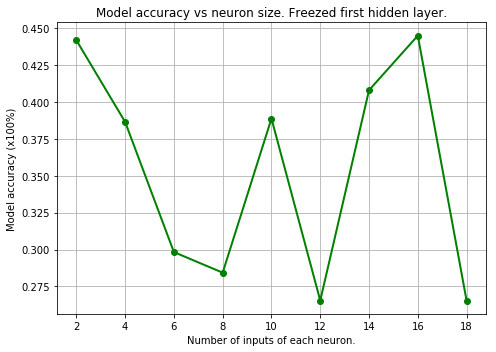

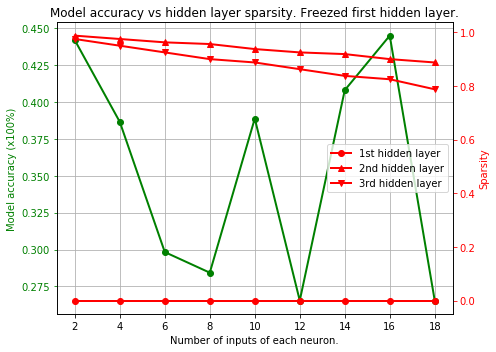

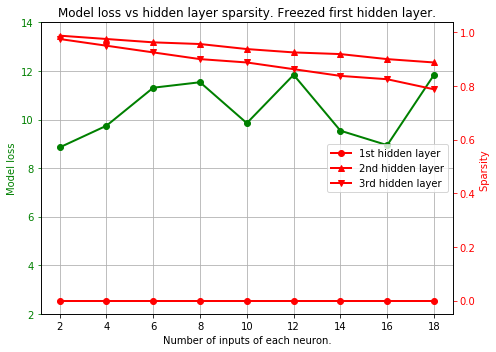

In [6]:
fig, ax1 = plt.subplots(figsize=(7,5))
X_axis = num_neuron_ips

ax1.plot(X_axis,model_accs,'go-', linewidth=2)
ax1.set_xlabel('Number of inputs of each neuron.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model accuracy (x100%)')
ax1.set_xticks(X_axis)
plt.grid(True)

plt.title('Model accuracy vs neuron size. Freezed first hidden layer.')
fig.tight_layout()

fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(X_axis,model_accs,'go-', linewidth=2)
ax1.set_xlabel('Number of inputs of each neuron.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model accuracy (x100%)', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity', color='r')
ax2.tick_params('y', colors='r')
plt.legend(loc='center right')
plt.title('Model accuracy vs hidden layer sparsity. Freezed first hidden layer.')
fig.tight_layout()

fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(X_axis,model_losses,'go-', linewidth=2)
ax1.set_xlabel('Number of inputs of each neuron.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model loss', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
ax1.set_yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity ', color='r')
ax2.tick_params('y', colors='r')
plt.legend()
plt.title('Model loss vs hidden layer sparsity. Freezed first hidden layer.')
fig.tight_layout()
print('Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}')
print('Each neuron of respective hidden layer has equal constrained sparsity. ')